Denoising NMR spectroscopy data

In [6]:
# -*- coding: utf-8 -*-
"""
Stationary Wavelet Denoising routine developed for Nuclear Magnetic Resonance
Spectra

Requires numpy and pywavelets
Created on Wed Mar 24 16:02:47 2021

@author: mason42@llnl.gov
"""

import numpy as np
import pywt
from scipy.ndimage.filters import maximum_filter
import matplotlib.pyplot as plt
import sys
# import functions as proc

C:\Users\chiar\AppData\Local\Temp\ipykernel_58536\474487986.py:14: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import maximum_filter


In [24]:
import scipy.io
directory ='C:/Users/chiar/Documents/tesi IBEC doc/script/FinalFolder/'
signal = scipy.io.loadmat(directory+ 'signal.mat')
signal = signal['signal'][0] 
data = signal[:len(signal)//2 * 2]  # Truncate data to the nearest even length
len(data)


16384

In [27]:
def wavelet_denoise(level, data, region_spec, wave = 'bior2.4', threshold = 'mod', alpha = 0):
    """
    Stationary wavelet based noise removal technique
    
    Parameters
    ----------
    level : int
        maximum level of the swt to be used for denoising
        typical values range from 5 to 7 for most NMR spectra
    data : ndarray
        real valued spectral data
        best results for unapodized data >16K points
    region_spec : ndarray
        binary spectrum of same length as data used for defining peak regions
    wave : str
        optional : descrete wavelet used for swt
        default : 'bior2.4'
        for a list of other wavelets use command pywt.wavelist(kind='discrete')
    threshold : str
        optional : choice of thresholding method
        default : 'mod'
        'mod' : modified thresholding technique
        'soft' : soft thresholding
        'hard' : hard thresholding
    alpha : float
        optional : alpha value for the modified thresholding
        default  : 1 all values must be >= 0 and <= 1
    
    Returns
    -------
    final : ndarray
        denoised spectrum the same length as the initial data
    coeffin : ndarray
        contains the detail and approximation components prior to thresholding
    coeffs : ndarray
        contains the detail and approximation components after thresholding
    """

    threshlist = ['mod', 'hard', 'soft', 'gar']
    wavelet_list = pywt.wavelist(kind='discrete')

    if threshold not in threshlist:
        raise ValueError("""Threshold method must be 'mod', 'soft', or 'hard'""")
    if wave not in wavelet_list:
        raise ValueError("""Unknown wavelet, please chose from: """, wavelet_list)
    if not 0 <= alpha <= 1:
        raise ValueError('alpha must be >= 0 and <= 1')
    
    coeffs=pywt.swt((data), wave,  level) #stationary wavelet transform

    # perform the stationary wavelet transorm (SWT) using the specified wavelet and decomposition level 

    coeffin = np.copy(coeffs)

    # creates a copy of the coefficients obtained from the wavelet transofrm and stores, the 'np.copy()' function is used to ensure that any modifications mate do 'coeffs' do not affect 'coeffin'

    ### This section calculates the lambdas at each level and removes noise
    ### from each using the chosen thresholding method

    for i in range(len(coeffs)):
        temp = coeffs[i]
        lam = calc_lamb(temp[0], region_spec) #lam comes from approx. component
        if threshold == 'soft':
            fincomp0 = soft_threshold(temp[0], lam)
            fincomp1 = soft_threshold(temp[1], lam)
        if threshold == 'hard':
            fincomp0 = hard_threshold(temp[0], lam)
            fincomp1 = hard_threshold(temp[1], lam)
        if threshold == 'mod':
            fincomp0 = mod_thresh(temp[0], lam, alpha)
            fincomp1 = mod_thresh(temp[1], lam, alpha)
        if threshold == 'gar':
            fincomp0 = gar_threshold(temp[0], lam)
            fincomp1 = gar_threshold(temp[1], lam)
        coeffs[i] = (fincomp0, fincomp1)
    #print('Lambda = %5.3f'%lam)
    final = pywt.iswt(coeffs, wave) #recontrusct the final denoised spectrum
    return final, coeffin, coeffs


def region_spec(data, nthresh = 4.5, buff_size = 200, filter_size = 2):
    """
    Generate a binary spectrum where peak regions = 1 and noise = 0
    
    Parameters
    ----------
    data : ndarray
        real valued spectral data
    nthresh : float
        optional : threshold use to define peak levels
        default  : 4.5 times the noise level
    buff_size : int
        optional : sets the number of points to add around the peaks
        default  : 200 pts
    filter_size : int
        optional : sets the minimum number of points to be considered a peak
        default  : 2 pts
    
    Returns
    -------
    fin_reg : ndarray
        binary spectrum the same length as the initial data defining peak regions
    """
    inp = find_peak_region(data, nthresh=nthresh)
    pidx = peak_indices(inp, buffer_size = buff_size, filter_size = filter_size)
    fin_reg = np.zeros(len(data))
    for i in range(len(pidx)):
        fin_reg[pidx[i,0]:pidx[i,1]] = 1
    return fin_reg

def find_peak_region(signal, thresh = 10, nthresh = 4.5):
    """
    Finds the peaks in the real data
    Follows a hybrid proceedure 
    0
    
    Parameters
    ----------
    sign  : ndarray
        derivitive of a FFT NMR data set
    thresh : int
        threshold for gaps in peaks as number of points
        default is 10 pts
    nthresh : float
        threshold use to define peak levels
        default is 4.5 times the noise level
    Returns
    -------
    regions : ndarray
        A binary array where 1 represents a peak region and 0 represents baseline
        
    """
    s0 = np.copy(signal)
    regions = np.zeros(len(s0))
    deriv = base_deriv(s0)
    #determine noise level for thresholding
    sn=int(0); nspts = len(s0) // 16
    tempNoise = np.zeros(16)
    for i in range(16):
        tempNoise[i] = np.std(deriv[sn+(i*nspts):nspts*(i+1)])
    noise = np.min(tempNoise)
    noise *= nthresh
    
    # use moving window to determine peak regions
    window = int(len(s0)*0.0015)
    regions = np.zeros(len(s0))
    for i in range(window, len(s0)-window):
        minr = np.min(np.abs(deriv[i-window:i+window]))
        maxr = np.max(np.abs(deriv[i-window:i+window]))
        delt = maxr-minr
        if delt > noise:
            regions[i] = 1
    #fill holes in the binary regions array
    for k in range(thresh,len(regions)-thresh):
        pn = regions[k+thresh-1]; nn = regions[k-thresh]
        #look thresh points away from the point of interest to fill holes and remove outliers
        if np.logical_and(regions[k] != pn, regions[k] != nn):
            regions[k] = pn
    return regions

def peak_indices(regions, buffer_size = 200, filter_size = 50):
    """
    Algorithm to transform binary region array into peak region indices
    and to merge and trim peak regions
    
    Parameters
    ----------
    regions : ndarray
        A binary array where 1 represents a peak region and 0 represents baseline
    buffer_size : int
        number of points to add to either side of a peak region
    filter_size : int
        minimum size for a peak region in number of points
    Returns
    -------
    indx : ndarray
        A two by n column matrix defining the start and end of a peak region
    """ 
    init_indx = np.where(regions == 1)[0]
    cons_indx = consecutive(init_indx)
    idx = np.array([]).astype(int)  #empty array for storage

    # loop through the consecutive blocks and find minimum and max values and add buffer points
    for i in range(len(cons_indx)):
        if len(cons_indx[i]) > filter_size:
            idx = np.append(idx, [int(np.min(cons_indx[i])-buffer_size), int(np.max(cons_indx[i])+buffer_size-1)])

    idx = idx.reshape((len(idx)//2, 2))

    # following code determines region overlaps and merges overlaping regions
    n, mn, mx = 1, 0, 0

    for k in range(0, len(idx)):
        if k == 0:
            mn = idx[0,0]
            mx = idx[0,1]
        elif idx[k,0]<=mx:  #there is overlap
            mx = idx[k,1]   #current max is always greater
            n += 1  #increment number in current group
            #print("n=", n, " max=", mx, " min=", mn)
            if k == len(idx)-1:  #last item in the array
                if n>1:
                    for i in range(0, n):  #set all prior items in group
                        idx[k-i, 0] = mn
                        idx[k-i, 1] = mx
        else:  #not overlapping; new group item 1
            if n>1:
                for i in range(1, n+1):  #set all prior items in group
                    idx[k-i, 0] = mn
                    idx[k-i, 1] = mx
            mx = idx[k, 1]
            mn = idx[k, 0]
            n = 1
    idx = np.unique(idx, axis = 0)
    return idx

def base_deriv(s0):
    """
    Function to determine signal derivative
    Uses equation 5 of Zorin et. al. Magn. Reson. Chem. 2017, 55, 738–746
    
    Parameters
    ----------
    s0  : ndarray
        The real component of a FFT array
    Returns
    -------
    deriv : ndarray
        The derivitive of the data, s0
    """
    deriv = np.zeros((len(s0)))
    for i in range(5,len(s0)-5):
        deriv[i] = (42*(s0[i] - s0[i-1]) + 48*(s0[i+1]-s0[i-2]) + 27*(s0[i+2]-s0[i-3]) + 8*(s0[i+3]-s0[i-4]) + s0[i+4]-s0[i-5])/512
    return deriv

def extract_windows(data, window_size):
    """
    
    Parameters
    ----------
    data : TYPE
        DESCRIPTION.
    window_size : TYPE
        DESCRIPTION.

    Returns
    -------
    TYPE
        DESCRIPTION.

    """
    start = window_size
    sub_windows = (
        start +
        np.expand_dims(np.arange(window_size), 0) +
        np.expand_dims(np.arange(len(data)-2*window_size) - int(window_size/2), 0).T
        )
    return data[sub_windows]

def region_spec2(data, thresh = 3, wndw = 30):
    """
    Generate a binary 2D spectrum where peak regions = 1 and noise = 0
    
    Parameters
    ----------
    data : ndarray
        real valued spectral data
    nthresh : float
        optional : threshold use to define peak levels
        default  : 3 times the noise level
    wndw : int
        optional : sets the number of points to add around the peaks
        default  : 30 pts
    
    Returns
    -------
    fin_reg : ndarray
        binary spectrum the same shape as the initial data defining peak regions
    """
    test = maximum_filter(data, size = 5)
    npts = [data.shape[0]//16, data.shape[1]//16]
    tempNoise = np.zeros((16,16))
    for i in range(16):
        for k in range(16):
            tempNoise[i,k] = np.std(test[(i*npts[0]):npts[0]*(i+1),
                                   (k*npts[1]):npts[1]*(k+1)])
    noise = thresh*np.mean(tempNoise)
    wdw = extract_windows(test, wndw)
    wdw = np.concatenate((np.zeros((wndw,wndw,data.shape[1])),
                          wdw, 
                          np.zeros((wndw,wndw,data.shape[1]))), axis = 0)
    
    mn = np.max(np.abs(wdw), axis = 1) - np.min(np.abs(wdw), axis = 1)
    fin_reg = 1-np.array([mn < noise][0]).astype(int)
    return fin_reg

def calc_lamb(data, region):
    """calculates the lambda value to use as the noise threshold
    
    Parameters
    ----------
    data: ndarray
        real valued data where the threshold is calculated
    region: ndarry
        binary spectrum that defines the peak and noise regions
        
    Returns
    -------
    lam: float
       value for the noise threshold"""
        
    if type(region) == int:
        if data.ndim == 1:
            noise = data[0:int(0.1*len(data))] 
        elif data.ndim ==2:
            #noise = data[0:int(0.1*len(data[:,0])),0:int(0.2*len(data[0,:]))]
            noise = data[0:int(0.1*len(data[:,0]))] 
    else:
        noise = np.zeros(data.shape)
        idx = np.where(region == 0)
        noise[idx] = data[idx]
            
    sig = np.std(noise)
    lam = sig*np.sqrt(2*np.log(len(data)))
    return lam

def hard_threshold(data, lam):
    """Hard Thresholding"""
    data_thr = np.copy(data)
    neg_idx = np.where(np.abs(data) < lam)
    data_thr[neg_idx] = 0
    return data_thr
    
def soft_threshold(data, lam):
    """Soft Thresholding"""
    data_thr = np.copy(data)
    pos_idx = np.where(data > lam)
    mid_idx = np.where(np.abs(data) <= lam)
    neg_idx = np.where(data < -lam)
    data_thr[pos_idx] = data[pos_idx] - lam
    data_thr[mid_idx] = 0
    data_thr[neg_idx] = data[neg_idx] + lam
    return data_thr

def mod_thresh(data, lam, alpha):
    """Modified thresholding using algorithm in:
    Wang and Dai, Proceedings of the 2018 International Symposium 
    on Communication Engineering & Computer Science (CECS 2018), 2018, 481"""
    data_thr = np.copy(data)
    pos_idx = np.where(np.abs(data) >= lam)
    neg_idx = np.where(np.abs(data) < lam)
    data_thr[pos_idx] = data[pos_idx] - alpha*(lam**4/data[pos_idx]**3)
    data_thr[neg_idx] = (1-alpha)*(data[neg_idx]**5/lam**4)
    return data_thr

def gar_threshold(data, lam):
    "garrote thresholding"
    data_thr = np.copy(data)
    pos_idx = np.where(np.abs(data) > lam)
    neg_idx = np.where(np.abs(data) <= lam)
    data_thr[pos_idx] = data[pos_idx] - lam**2/data_thr[pos_idx]
    data_thr[neg_idx] = 0
    return data_thr

def consecutive(data, stepsize=1):
    """"
    basic function to blocks of consecutive number in an array
    """
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

In [15]:
Region = region_spec(signal, nthresh = 4.5, buff_size = 200, filter_size = 2)

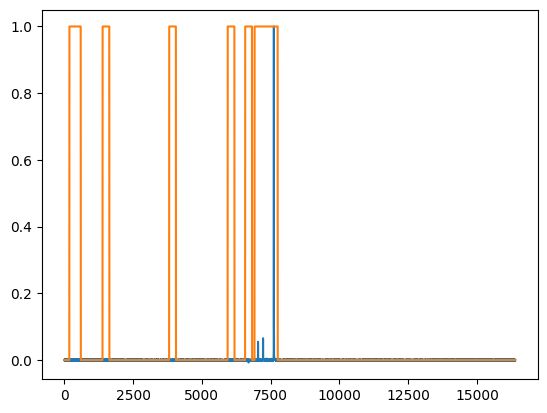

In [14]:
plt.plot(signal/max(signal))
plt.plot(Region)

In [26]:
denoise = wavelet_denoise(5, signal, region_spec, wave = 'bior2.4', threshold = 'mod', alpha = 0)

ValueError: Length of data must be even.